# Импорты

Импорт всех необходимых библиотек

In [2]:
%pip install -q catboost
%pip install -q optuna


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
%pip install -q shap


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFClassifier
from sklearn.model_selection import cross_validate, cross_val_score
from shap import TreeExplainer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

In [6]:
import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from optuna.samplers import RandomSampler, TPESampler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
import catboost

In [7]:
import warnings
warnings.filterwarnings("ignore")

Импорт датасета

In [8]:
df = pd.read_csv('db_subset.csv')
df

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
0,NaN,NaN,NaN,NaN,0.04,11.03,21.41,128.17,495.78,0.72,0.04,0.93,NaN,NaN,0.75,0.08,378.50,NaN,NaN,0.32,19.83,2.25,NaN,NaN,NaN,28.18,0.04,26.83,NaN,8.00,0.06,0.05,0.03,0.04,49.00,NaN,NaN,NaN,NaN,NaN,33.75,0.02,NaN,NaN,0.72,0.06,NaN,NaN,50.00,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,0.66,0.11,NaN,NaN,0.21,NaN,NaN,0.17,0,0,0,0,NaN,0
1,NaN,NaN,NaN,NaN,0.02,10.72,12.43,77.82,727.72,0.37,0.02,0.66,NaN,NaN,0.64,0.05,324.95,NaN,NaN,0.19,15.86,0.94,NaN,NaN,NaN,17.79,0.02,23.26,NaN,4.80,0.04,0.06,0.05,0.02,45.40,NaN,NaN,NaN,NaN,NaN,26.08,0.01,NaN,NaN,0.48,0.04,NaN,NaN,30.00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,1.12,0.11,NaN,NaN,0.24,NaN,NaN,0.15,0,0,0,0,NaN,0
2,NaN,NaN,NaN,NaN,0.04,25.63,19.99,147.13,373.79,0.93,0.04,1.11,NaN,NaN,1.00,0.08,354.73,NaN,NaN,0.34,25.80,4.77,NaN,NaN,NaN,28.46,0.04,29.70,NaN,8.83,0.07,0.03,0.02,0.05,37.83,NaN,NaN,NaN,NaN,NaN,35.00,0.02,NaN,NaN,0.73,0.06,NaN,NaN,53.22,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,0.11,0.10,NaN,NaN,0.32,NaN,NaN,0.26,1,0,0,0,NaN,0
3,NaN,NaN,NaN,0.53,0.06,4.42,NaN,2.27,0.42,NaN,0.03,0.14,0.01,0.01,0.02,0.01,2.45,NaN,0.01,0.22,0.12,NaN,NaN,NaN,0.01,NaN,0.02,0.19,NaN,0.02,0.00,0.00,0.00,0.00,0.02,0.01,0.43,NaN,NaN,0.01,1.45,0.00,NaN,0.00,0.02,0.01,NaN,0.01,NaN,0.01,0.00,0.00,0.00,NaN,0.01,NaN,NaN,0.01,0.04,NaN,0.01,NaN,0.00,0.00,NaN,NaN,0.17,NaN,NaN,0.03,0,0,0,0,NaN,0
4,NaN,NaN,NaN,1.08,0.05,1.34,NaN,2.94,1.04,NaN,0.05,0.33,0.03,0.02,0.02,0.00,5.97,NaN,0.02,0.10,0.20,NaN,NaN,NaN,0.02,NaN,0.05,0.40,NaN,0.09,0.00,0.00,0.00,0.00,0.10,0.03,0.82,NaN,NaN,0.04,3.32,0.00,NaN,0.01,0.05,0.00,NaN,0.02,NaN,0.02,NaN,0.01,0.00,NaN,0.02,NaN,NaN,0.03,0.07,NaN,0.02,0.01,0.00,0.00,NaN,NaN,0.26,NaN,NaN,0.08,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,30.2,67.3,42.4,477.17,24.50,1797.91,82.62,1354.90,1223.05,12.31,10.50,55.08,1.96,1.71,11.42,5.57,2305.47,17.34,0.88,56.86,760.68,2.33,0.60,15.07,1.44,163.39,9.33,217.28,8.92,466.08,1.00,1.51,2.84,0.95,218.19,3.14,182.73,62.20,0.02,2.45,961.52,0.84,0.02,0.81,11.14,4.89,0.01,1.30,109.94,1.30,1.29,0.38,3.59,60.64,1.41,0.88,6.67,2.51,10.56,181.60,113.14,4.17,4.55,0.73,9.21,24.18,60.15,68.55,6.56,4.58,1,0,0,1,35.986159,0
2881,36.1,77.1,51.6,1867.95,34.70,3373.56,81.50,2929.34,3550.36,20.59,32.17,185.21,11.50,9.37,27.31,23.95,5804.66,45.02,5.17,104.79,1344.17,8.78,0.25,31.35,8.34,270.83,28.52,534.18,7.92,5607.64,2.03,3.12,10.60,3.72,589.55,30.73,406.35,1249.62,0.33,14.14,2606.66,5.33,0.10,4.66,35.63,13.19,0.02,7.10,295.28,7.91,2.22,1.99,12.16,142.43,7.68,2.35,48.00,13.78,35.43,330.24,372.68,6.19,9.96,2.34,8.96,16.95,254.15,179.18,6.91,24.05,1,0,0,1,59.519091,1
2882,19.9,47.5,27.9,356.44,33.42,3321.43,115.59,2744.22,2027.59,34.25,17.10,103.58,5.77,4.63,26.87,42.02,5027.29,36.82,2.78,134.74,875.24,28.08,3.20,116.85,4.18,252.72,14.96,500.51,26.21,1060.56,2.15,2.15,6.73,3.05,417.65,6.31,185.98,141.09,0.33,7.05,1565.

<Axes: ylabel='Count'>

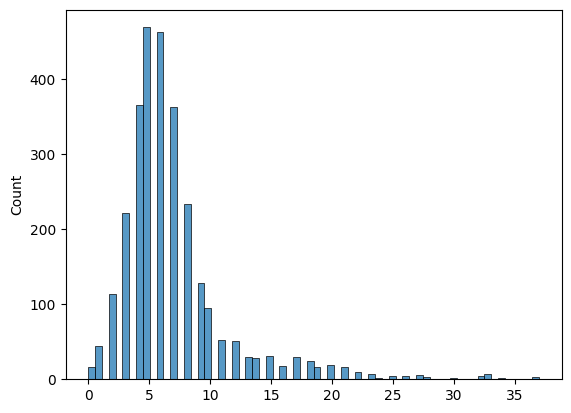

In [9]:
missing_features = df.isnull().sum(axis=1)
sns.histplot(missing_features)

# Предобработка датасета

Все признаки имеют числовой вид, посмотрим на распределение классов

In [10]:
df = df.drop(df[df['bmi']>80].index)

In [11]:
df.loc[df['target'] == 0]['target'].count(), df.loc[df['target'] == 1]['target'].count()

(1871, 1011)

<Axes: xlabel='target', ylabel='Count'>

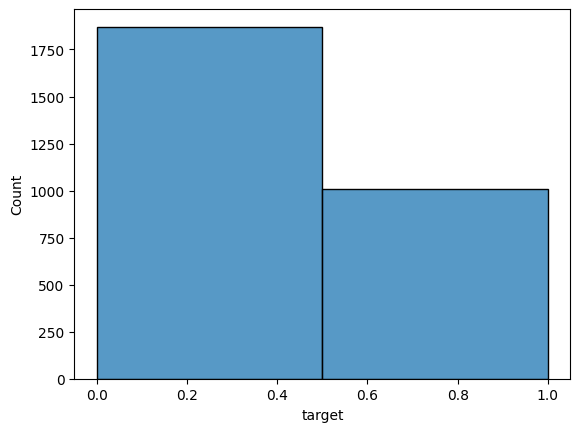

In [12]:
sns.histplot(df['target'], bins = 2)

Классы находятся в соотношении 2:1, будем считать, что они сбалансированы.

Теперь посмотрим на признаки объектов:

In [13]:
df.columns, len(df.columns)

(Index(['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир',
        'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна',
        'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир',
        'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь',
        'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота',
        'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.',
        'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин',
        'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p',
        'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'галактоза',
        'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол',
        'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b',
        'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co',
        'марганец_mn', 'медь_cu', 'молибден_mo', 'никель_ni', 'селен_se',
        'фтор_f', 'хром_

Поделим датасет на тренировочную и тестовую выборки, отнормируем их, а затем уже попробуем выбрать наиболее значимые признаки.

<Axes: xlabel='bmi', ylabel='Count'>

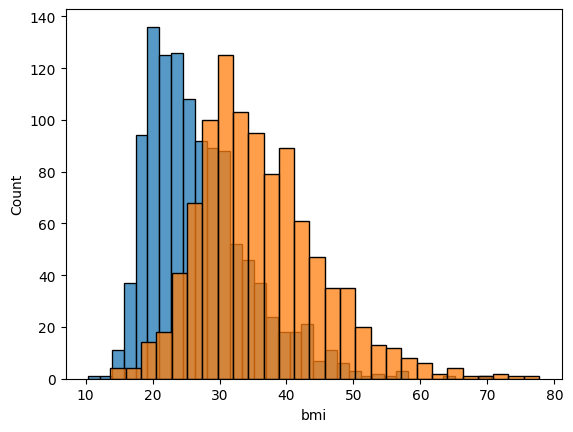

In [14]:
sns.histplot(df[df['target']==0]['bmi'], legend=True)
sns.histplot(df[df['target']==1]['bmi'], legend=True)

In [15]:
df_test = pd.concat([df[df['bmi']<35][df['bmi']>25][df['target']==0].sample(n=216),
                    df[df['bmi']<35][df['bmi']>25][df['target']==1].sample(n=216)])
df_test

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
2647,NaN,NaN,NaN,672.81,40.71,2637.44,123.91,2656.63,1970.55,21.72,40.67,136.85,10.16,7.29,20.93,20.03,4561.22,11.51,4.75,134.04,846.20,13.81,NaN,90.95,6.68,212.16,36.83,460.92,9.16,485.51,1.75,2.66,6.04,3.04,328.63,9.15,404.37,223.20,0.04,11.60,1920.36,2.97,0.05,3.74,23.16,22.42,0.02,5.44,164.24,6.24,1.37,1.69,15.75,70.77,6.03,2.57,240.0,11.07,33.45,206.07,173.20,19.27,4.40,2.03,12.07,25.73,170.96,135.95,10.60,26.29,1,0,0,0,30.835492,0
2818,21.09,47.48,31.72,582.65,35.73,5753.81,59.44,2717.40,2325.01,14.92,24.83,93.05,4.14,2.97,22.67,32.67,3321.32,39.10,1.52,118.56,723.00,54.43,0.10,20.80,2.64,220.69,22.63,400.88,2.66,383.91,0.80,1.75,3.69,1.59,252.72,3.47,311.43,16.38,NaN,4.50,1528.50,1.09,0.03,1.36,12.39,17.58,0.08,2.10,62.10,2.36,1.00,0.65,21.09,98.51,2.54,0.83,48.0,4.52,20.60,173.32,242.16,3.72,4.14,1.25,2.17,4.49,97.39,467.50,2.08,8.94,1,0,0,1,29.922090,0
1162,NaN,NaN,NaN,863.03,36.33,3097.35,85.56,2097.72,2368.46,23.15,21.04,127.64,6.60,5.13,25.92,13.42,5102.40,10.31,2.68,94.14,1370.11,1.30,NaN,62.83,4.60,189.32,18.80,443.90,23.24,1523.37,1.46,2.45,7.69,2.35,343.98,4.86,259.78,NaN,NaN,7.40,2005.04,1.06,NaN,2.47,26.22,11.27,0.01,3.77,265.88,4.08,1.78,1.07,11.10,90.00,4.10,5.06,20.0,7.48,22.38,230.67,135.83,22.14,5.42,1.95,42.00,98.80,129.18,210.51,29.20,14.66,0,1,0,1,31.919308,0
1985,23.40,54.70,33.50,755.48,14.61,1277.09,30.08,1293.72,1459.00,18.97,21.25,76.33,4.65,3.68,16.75,12.46,3302.46,12.27,1.93,56.80,570.44,0.64,NaN,85.47,3.20,119.53,19.52,358.20,6.09,1196.78,1.26,1.68,6.32,1.85,346.51,6.98,320.59,100.03,0.50,5.41,1219.24,2.09,NaN,1.71,19.57,10.66,0.03,2.67,182.14,2.90,2.28,0.82,12.30,0.01,3.03,5.66,NaN,5.24,15.97,0.80,208.28,20.01,5.36,1.62,19.60,35.90,99.92,150.02,15.73,11.65,1,0,0,1,32.297866,0
2447,NaN,45.60,23.60,1576.43,72.49,9820.43,106.36,3798.77,1805.35,27.12,43.15,222.40,10.98,8.86,44.12,35.15,4954.62,77.23,4.80,211.02,1700.47,0.81,NaN,74.67,7.47,246.80,38.45,634.71,5.92,1001.20,2.23,4.27,9.67,2.95,422.76,17.74,682.08,0.01,0.17,13.70,3244.79,6.40,NaN,4.53,27.45,14.99,0.06,6.78,145.98,7.18,11.92,2.07,36.31,0.01,6.92,4.23,48.0,12.82,36.09,6.73,665.20,84.46,2.53,2.85,34.82,45.55,214.34,140.80,23.70,20.37,1,0,1,0,26.297578,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,19.60,46.40,26.20,712.40,74.01,5483.33,248.04,4021.83,3808.00,53.54,40.56,130.83,5.97,4.54,35.07,26.52,7285.17,78.72,2.76,198.31,1726.54,1.84,16.00,89.07,3.99,462.25,36.14,671.50,49.55,1118.86,2.91,3.28,7.45,2.92,539.91,4.77,321.56,66.67,NaN,6.74,2249.96,2.41,0.06,2.12,36.69,21.52,0.04,3.29,437.39,3.67,2.25,1.07,24.87,NaN,3.83,7.91,40.0,6.81,33.44,58.63,100.34,24.37,7.05,2.56,51.73,147.93,122.42,195.47,43.20,16.12,1,0,1,0,28.440955,1
464,47.60,50.60,NaN,449.19,13.02,582.68,2.47,731.06,1000.15,0.16,11.37,71.91,5.29,4.00,6.27,8.48,1366.52,0.97,2.23,37.74,287.23,NaN,NaN,0.60,3.66,7.62,9.15,125.82,0.06,362.82,0.37,1.07,4.08,1.40,82.36,6.35,74.41,66.6

In [16]:
df_temp = df.drop(df_test.index)
x_temp = df_temp.drop(columns=['target'])
y_temp = df_temp['target']
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.15, random_state=42)
x_test = df_test.drop(columns=['target'])
y_test = df_test['target']

In [17]:
column_names = x_train.columns

In [18]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_val = pd.DataFrame(scaler.transform(x_val))
x_test = pd.DataFrame(scaler.transform(x_test))

In [19]:
column_dict = {a: column_names[a] for a in range(len(x_train.columns))}
column_dict

{0: 'внутриклеточная_жидкость',
 1: 'тощая_мт',
 2: 'акм',
 3: 'холестерин',
 4: 'нас._жир',
 5: 'натрий_na',
 6: 'сахара',
 7: 'энергия',
 8: 'вода',
 9: 'пищ._волокна',
 10: 'мононенас._жир',
 11: 'белки',
 12: 'аргинин',
 13: 'валин',
 14: 'зола',
 15: 'полиненас._жир',
 16: 'калий_k',
 17: 'крахмал',
 18: 'гистидин',
 19: 'жиры',
 20: 'кальций_ca',
 21: 'алкоголь',
 22: 'кремний_si',
 23: 'сера_s',
 24: 'изолейцин',
 25: 'углеводы',
 26: 'олеиновая_кислота',
 27: 'магний_mg',
 28: 'фруктоза',
 29: 'a',
 30: 'b1_тиамин',
 31: 'b2_рибофлав.',
 32: 'b5_пантотен._кис.',
 33: 'b6_пиридоксин',
 34: 'b9_фолаты',
 35: 'b12_кобаламин',
 36: 'b4_холин',
 37: 'β-каротин',
 38: 'ретин._эквив.',
 39: 'лейцин',
 40: 'фосфор_p',
 41: 'омега-3',
 42: 'лактоза',
 43: 'метионин',
 44: 'железо_fe',
 45: 'омега-6',
 46: 'галактоза',
 47: 'метионин+цистеин',
 48: 'c',
 49: 'треонин',
 50: 'd',
 51: 'триптофан',
 52: 'e_α-токоферол',
 53: 'гамма-линолен._к-та',
 54: 'фенилаланин',
 55: 'h_биотин',
 56: 

In [20]:
x_train = x_train.rename(columns=column_dict)
x_val = x_val.rename(columns=column_dict)
x_test = x_test.rename(columns=column_dict)
x_train

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi
0,NaN,NaN,NaN,-0.603141,-0.426307,-0.488594,-0.663771,-0.575730,-0.729507,-0.637399,-0.411073,-0.658399,-0.722983,-0.753751,-0.753018,-0.383297,-0.701918,-0.178302,-0.760744,-0.506741,-0.620954,-0.344197,NaN,-0.322957,-0.741798,-0.531207,-0.386501,-0.763752,-0.751141,-0.695490,-0.591013,-0.780071,-0.633298,-0.712547,-0.797727,-0.758125,-0.704961,-0.286082,NaN,-0.760720,-0.700290,-0.394645,NaN,-0.701040,-0.844527,-0.044365,-0.375420,-0.741660,-0.753078,-0.757243,-0.217806,-0.782939,-0.537751,NaN,-0.793116,-0.248328,-0.844570,-0.761111,-0.722717,-0.561258,-0.802340,-0.725873,-0.705260,-0.719388,-0.994606,-0.916918,-0.703969,-0.961223,-0.996706,-0.753621,1.082133,-0.282623,2.151053,-0.688843,-1.061033
1,NaN,0.133404,NaN,0.839678,0.677539,0.420780,0.107485,0.501840,0.361285,0.040606,0.467444,0.743766,0.649049,0.766924,0.246230,-0.159908,-0.023968,-0.134668,0.837591,0.394124,0.565304,0.481644,-0.125150,-0.038139,0.755061,0.255537,0.461137,0.140429,-0.373414,-0.192340,0.532798,0.521122,0.343392,0.244467,0.377338,0.262706,0.626183,-0.528040,-0.149721,0.774049,0.568189,0.277398,NaN,0.828821,0.105863,0.268783,-0.228936,0.829725,-0.182553,0.738712,0.184851,0.768903,-0.359954,NaN,0.758885,0.013550,-0.463147,0.807565,0.681942,-0.520294,-0.596646,-0.098823,-0.191954,0.124375,-0.507041,-0.511884,1.045615,1.177543,-0.550503,0.433060,1.082133,-0.282623,-0.464889,1.451710,1.255281
2,-0.705763,-1.002551,-1.122187,1.268869,0.089732,-0.097386,-0.477485,-0.229488,-0.564159,-0.461748,0.000055,-0.003138,-0.257010,-0.216054,-0.241562,0.092532,-0.508978,-0.433393,-0.361160,0.053315,-0.082617,-0.133222,-0.125150,-0.188033,-0.269858,-0.495391,0.037318,-0.231885,-0.534174,-0.018821,-0.366251,0.188258,-0.100326,-0.534498,-0.251445,-0.227293,1.292476,-0.544353,-0.303413,-0.269373,0.011784,-0.342950,-0.236186,-0.282251,-0.245761,0.059728,-0.228936,-0.221633,-0.560752,-0.326205,0.371316,-0.253487,0.158029,NaN,-0.188706,-0.160585,-0.377799,-0.225814,-0.543548,-0.554285,0.217746,-0.392908,-0.475514,-0.343530,-0.593517,-0.559126,-0.117760,-0.000109,-0.565325,-0.265541,1.082133,-0.282623,-0.464889,1.451710,-0.667191
3,NaN,NaN,NaN,-1.104974,-1.049048,-0.078070,0.103872,0.112874,-0.318588,1.400500,-0.647472,0.073836,-0.600017,-0.623528,0.359208,-0.456925,0.437701,1.624421,-0.703661,-0.883096,-0.381525,NaN,-0.056922,1.690662,-0.641689,1.134035,-0.599293,0.522128,-0.120185,-0.458295,1.431848,-0.265646,1.116073,0.415097,0.875932,-0.894917,-0.579079,NaN,NaN,-0.592337,-0.007192,-0.187863,NaN,-0.803600,0.752182,-0.376597,-0.375420,-0.645568,0.005610,-0.650751,-0.369141,-0.490827,-0.249719,NaN,-0.465301,1.620360,1.351576,-0.592221,0.320804,-0.486999,-0.061669,1.131351,0.244770,0.991150,-0.146913,-0.178552,0.182808,0.811610,0.240492,0.188432,-0.924101,-0.282623,-0.464889,-0.688843,NaN
4,NaN,-0.152245,-0.620114,-0.266254,-0.372767,-0.080526,-0.604841,-0.391781,-0.303189,-0.317602,0.132049,-0.524262,-0.564422,-0.589922,-0.438511,-0.175936,-0.539533,-0.263586,-0.625171,-0.300654,-0.580736,-0.298391,-0.176321,-0.209733,-0.613087,-0.371731,0.180746,-0.366658,-0.624225,-0.436607,-0.373275,-0.379122,-0.413989,-0.593847,-0.246550,-0.576417,-0.150438,0.

Видно, что в датасете есть утечки данных (значения NaN), классический Random Forest Classifier из sklearn.ensemble не может работать с такими данными, поэтому есть несколько вариантов дальнейшей работы:


1.   Работать с моделями, которые поддерживают работу с пропусками в данных
2.   Устранить пропуски при помощи Imputer-а, и обработать его классическим RF

Причем поиск оптимальных параметров для RF будет производиться при помощи GridSearchCV



## Отбор признаков get_feature_importance из CatBoost

In [21]:
model = CatBoostClassifier(random_seed=42)
model.fit(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)
model.get_feature_importance(catboost.Pool(x_train))

Learning rate set to 0.037982
0:	learn: 0.6682885	test: 0.6865473	best: 0.6865473 (0)	total: 56.8ms	remaining: 56.7s
200:	learn: 0.2332468	test: 0.6309899	best: 0.6287749 (155)	total: 862ms	remaining: 3.43s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6247344084
bestIteration = 296

Shrink model to first 297 iterations.


array([ 0.8139255 ,  2.74869278,  1.0252904 ,  0.94614327,  0.56133891,
        0.98551005,  1.40670842,  0.50574184,  0.85011473,  0.56342724,
        0.99035599,  0.39921159,  0.35082325,  0.66545984,  1.02940788,
        1.54584348,  0.3842216 ,  1.16968498,  0.70795939,  0.74169995,
        1.58173433,  1.45750121,  1.07081756,  1.02357275,  0.84378976,
        1.21102267,  0.63895626,  1.00342385,  1.43107403,  0.65163437,
        0.48015706,  0.67261434,  0.68575547,  1.18241649,  1.13518245,
        1.39427944,  1.01912371,  2.51706716,  2.14880677,  0.90701842,
        0.40774844,  1.08937544,  2.08651521,  0.97739229,  0.8241942 ,
        1.61505013,  1.75123073,  0.40472588,  1.59779144,  0.87221113,
        1.62960321,  0.31638726,  0.90599107,  0.59767924,  0.25859084,
        1.76662176,  0.80056625,  0.66880067,  0.37357595,  1.6344635 ,
        1.07885849,  0.9097654 ,  2.08648467,  0.5751458 ,  1.1487902 ,
        0.67938205,  0.91135282,  0.86602596,  0.78672565,  0.52

<BarContainer object of 75 artists>

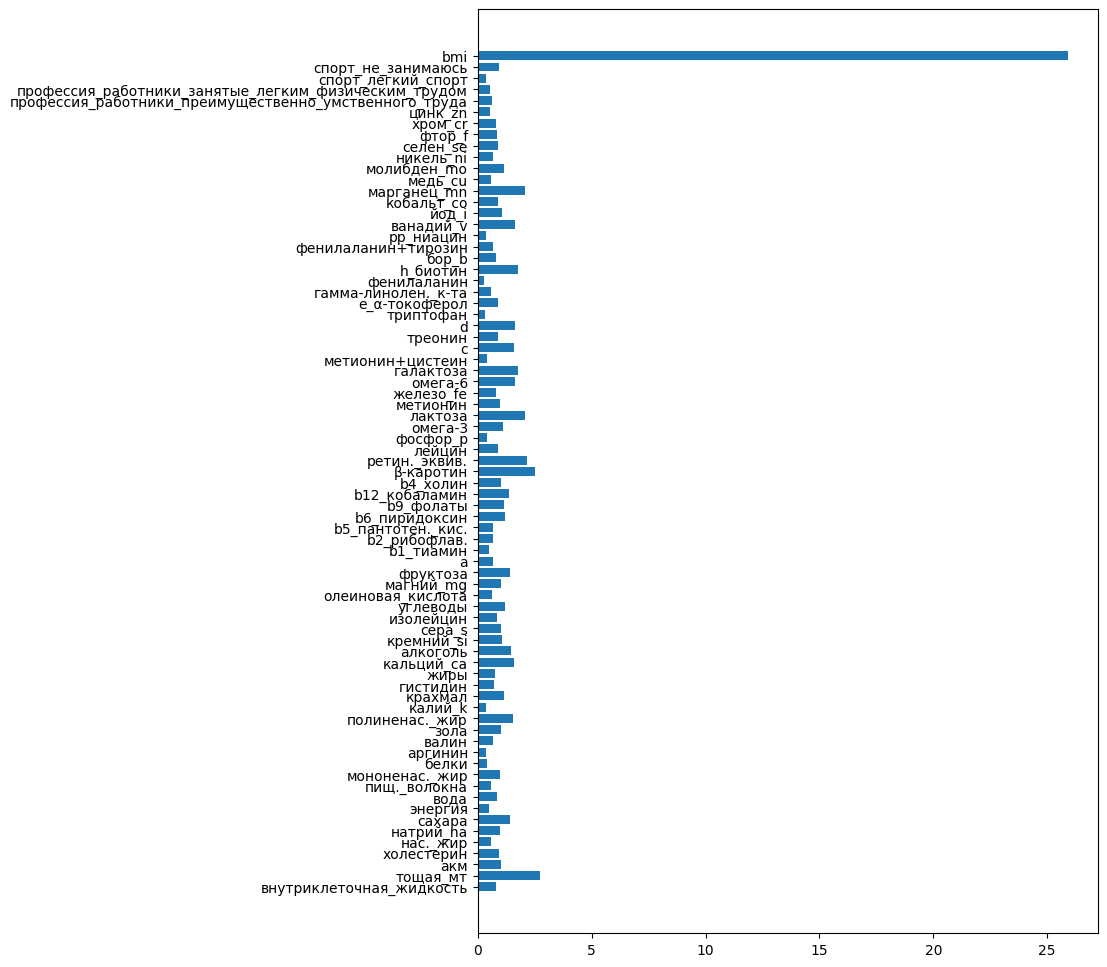

In [22]:
plt.figure(figsize=(8,12))
plt.barh(column_names, model.get_feature_importance(catboost.Pool(x_train)))

In [23]:
import heapq
importances = model.get_feature_importance(catboost.Pool(x_train))
max_imp = heapq.nlargest(9, importances)

features_selected_indx = np.where(np.isin(importances, max_imp))[0]
features_selected_indx

array([ 1, 37, 38, 42, 46, 55, 59, 62, 74])

In [24]:
features_selected = list(df.columns[features_selected_indx])
features_selected

['тощая_мт',
 'β-каротин',
 'ретин._эквив.',
 'лактоза',
 'галактоза',
 'h_биотин',
 'ванадий_v',
 'марганец_mn',
 'bmi']

## Финальный набор признаков

Убираем из признаков ИМТ

In [25]:
features_selected.remove('bmi')
features_selected

['тощая_мт',
 'β-каротин',
 'ретин._эквив.',
 'лактоза',
 'галактоза',
 'h_биотин',
 'ванадий_v',
 'марганец_mn']

In [26]:
features_selected_indx = []
for i in features_selected: features_selected_indx.append(list(x_train.columns).index(i))
features_selected_indx = sorted(features_selected_indx)
features_selected_indx

[1, 37, 38, 42, 46, 55, 59, 62]

In [27]:
x_train_selected = x_train.iloc[:,features_selected_indx]
x_val_selected = x_val.iloc[:,features_selected_indx]
x_test_selected = x_test.iloc[:,features_selected_indx]

<Axes: ylabel='Count'>

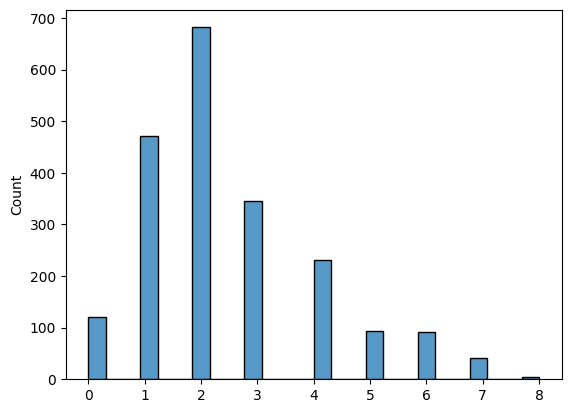

In [28]:
missing_features_selected = x_train_selected.isnull().sum(axis=1)
sns.histplot(missing_features_selected)

<Axes: ylabel='Count'>

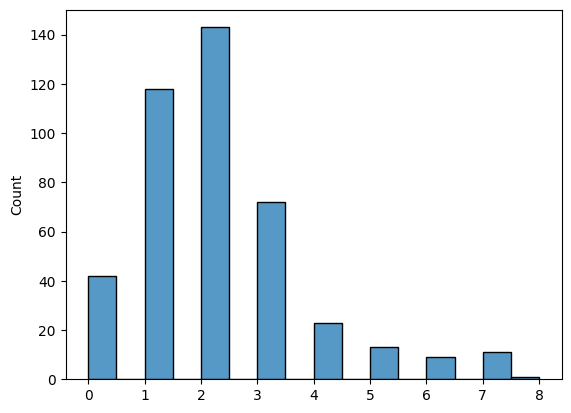

In [29]:
missing_features_selected = x_test_selected.isnull().sum(axis=1)
sns.histplot(missing_features_selected)

Видно, что в тренировочной и тестовой выборках с отобранными 9 параметрами, подавляющее большинство строк имеют 6 значимых признаков и более. Соответственно, на отобранных данных можн проводить обучение.

# Обучение моделей

Для работы с моделями будет использоваться алгоритм кросс-валидации для проверки значений метрик на тренировочной выборке, а итоговые значения метрик будут получаться на тестовой выборке.

Подбор оптимальных параметров происходит при помощи Optuna.

## 1. Рандомный лес

### 1. Imputer + RandomForest

In [30]:
it_imp = SimpleImputer(missing_values=np.nan, strategy='mean') #IterativeImputer(random_state=42)
x_train_imp = it_imp.fit_transform(x_train)
x_val_imp = it_imp.transform(x_val)
x_test_imp = it_imp.transform(x_test)

In [31]:
def param_search_rf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1)
    }

    model = RandomForestClassifier(**params)
    model.fit(x_train_imp, y_train)
    predictions = model.predict(x_test_imp)
    return f1_score(y_test, predictions)

In [32]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(param_search_rf, n_trials=30)

[I 2024-11-24 12:22:23,416] A new study created in memory with name: no-name-0e177316-d3f8-4e25-b9fd-16c78e85498b
[I 2024-11-24 12:22:25,252] Trial 0 finished with value: 0.4444444444444444 and parameters: {'max_depth': 9, 'n_estimators': 200, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.4444444444444444.
[I 2024-11-24 12:22:28,806] Trial 1 finished with value: 0.4339622641509434 and parameters: {'max_depth': 8, 'n_estimators': 400, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.4444444444444444.
[I 2024-11-24 12:22:36,054] Trial 2 finished with value: 0.43260188087774293 and parameters: {'max_depth': 7, 'n_estimators': 900, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.4444444444444444.
[I 2024-11-24 12:22:41,752] Trial 3 finished with value: 0.45820433436532504 and parameters: {'max_depth': 10, 'n_estimators': 600, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 3 with value:

In [33]:
print('Best hyperparameters:', study_rf.best_params)
print('Best ROC-AUC score:', study_rf.best_value)

Best hyperparameters: {'max_depth': 9, 'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 3}
Best ROC-AUC score: 0.462962962962963


In [34]:
rfc_best = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                  max_depth = study_rf.best_params['max_depth'],
                                  min_samples_split = study_rf.best_params['min_samples_split'],
                                  min_samples_leaf = study_rf.best_params['min_samples_leaf'],
                                  criterion='log_loss')
rfc_best.fit(x_train_imp, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=9, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=200)

Метрики, получаемые из кросс-валидации

In [35]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(rfc_best, x_train_imp, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([1.42974043, 1.48145652, 1.43331838, 1.4803586 , 1.47770977]),
 'score_time': array([0.05433655, 0.04771352, 0.04684281, 0.05253577, 0.04788494]),
 'test_accuracy': array([0.79376499, 0.81055156, 0.80288462, 0.82451923, 0.81009615]),
 'test_precision_macro': array([0.77467694, 0.79222462, 0.78049978, 0.80944549, 0.79230541]),
 'test_recall_macro': array([0.73694264, 0.76267794, 0.75595097, 0.77773824, 0.7593647 ]),
 'test_f1_macro': array([0.74967891, 0.77384409, 0.76555326, 0.78983356, 0.7714842 ]),
 'test_roc_auc': array([0.85301968, 0.88135859, 0.85575326, 0.87051536, 0.87325689])}

In [36]:
from sklearn.metrics import fbeta_score

def f2_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

In [37]:
def f2_score_on_pr_rec(precision, recall):
  return (5*precision*recall)/(4*precision+recall)

In [38]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
rfc_best_cv_metrics = []
for metric in metrics: rfc_best_cv_metrics.append(scores[metric])
rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
rfc_best_cv_metrics = np.array(rfc_best_cv_metrics)

In [39]:
def report(y_true, y_pred):
  print(classification_report(y_true, y_pred))
  cm = confusion_matrix(y_true, y_pred, normalize="all")
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, cmap="Reds")
  print("F2-score: ", f2_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.84      0.67       216
           1       0.68      0.33      0.44       216

    accuracy                           0.59       432
   macro avg       0.62      0.59      0.56       432
weighted avg       0.62      0.59      0.56       432

F2-score:  0.36635706914344685


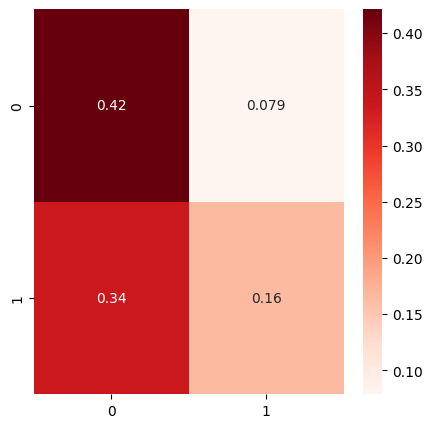

In [40]:
report(y_test, rfc_best.predict(x_test_imp))

### 2. XGBRFClassifier

In [41]:
def param_search_xgbrf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
    }

    model = XGBRFClassifier(**params)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [42]:
study_xgbrf = optuna.create_study(direction='maximize')
study_xgbrf.optimize(param_search_xgbrf, n_trials=30)

[I 2024-11-24 12:24:35,059] A new study created in memory with name: no-name-6c122add-f97f-4319-9593-ba84c4d7ca2c


[12:24:35] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:35,684] Trial 0 finished with value: 0.4705882352941176 and parameters: {'max_depth': 4, 'n_estimators': 500}. Best is trial 0 with value: 0.4705882352941176.


[12:24:35] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:36,043] Trial 1 finished with value: 0.4290030211480363 and parameters: {'max_depth': 3, 'n_estimators': 500}. Best is trial 0 with value: 0.4705882352941176.


[12:24:36] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:38,063] Trial 2 finished with value: 0.5242165242165242 and parameters: {'max_depth': 9, 'n_estimators': 700}. Best is trial 2 with value: 0.5242165242165242.


[12:24:38] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:39,067] Trial 3 finished with value: 0.48071216617210677 and parameters: {'max_depth': 5, 'n_estimators': 800}. Best is trial 2 with value: 0.5242165242165242.


[12:24:39] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:39,415] Trial 4 finished with value: 0.49266862170087977 and parameters: {'max_depth': 6, 'n_estimators': 200}. Best is trial 2 with value: 0.5242165242165242.


[12:24:39] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:39,747] Trial 5 finished with value: 0.49266862170087977 and parameters: {'max_depth': 6, 'n_estimators': 200}. Best is trial 2 with value: 0.5242165242165242.


[12:24:39] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:42,650] Trial 6 finished with value: 0.523943661971831 and parameters: {'max_depth': 10, 'n_estimators': 900}. Best is trial 2 with value: 0.5242165242165242.


[12:24:42] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:42,981] Trial 7 finished with value: 0.5292479108635098 and parameters: {'max_depth': 10, 'n_estimators': 100}. Best is trial 7 with value: 0.5292479108635098.


[12:24:42] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:43,553] Trial 8 finished with value: 0.42424242424242425 and parameters: {'max_depth': 3, 'n_estimators': 800}. Best is trial 7 with value: 0.5292479108635098.


[12:24:43] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:43,993] Trial 9 finished with value: 0.42553191489361697 and parameters: {'max_depth': 3, 'n_estimators': 600}. Best is trial 7 with value: 0.5292479108635098.


[12:24:44] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:44,268] Trial 10 finished with value: 0.515759312320917 and parameters: {'max_depth': 8, 'n_estimators': 100}. Best is trial 7 with value: 0.5292479108635098.


[12:24:44] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:45,622] Trial 11 finished with value: 0.5333333333333333 and parameters: {'max_depth': 10, 'n_estimators': 400}. Best is trial 11 with value: 0.5333333333333333.


[12:24:45] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:46,607] Trial 12 finished with value: 0.538888888888889 and parameters: {'max_depth': 10, 'n_estimators': 300}. Best is trial 12 with value: 0.538888888888889.


[12:24:46] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:47,718] Trial 13 finished with value: 0.5337078651685393 and parameters: {'max_depth': 9, 'n_estimators': 400}. Best is trial 12 with value: 0.538888888888889.


[12:24:47] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:48,437] Trial 14 finished with value: 0.5299145299145299 and parameters: {'max_depth': 8, 'n_estimators': 300}. Best is trial 12 with value: 0.538888888888889.


[12:24:48] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:49,413] Trial 15 finished with value: 0.5272206303724929 and parameters: {'max_depth': 8, 'n_estimators': 400}. Best is trial 12 with value: 0.538888888888889.


[12:24:49] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:50,245] Trial 16 finished with value: 0.5325779036827196 and parameters: {'max_depth': 9, 'n_estimators': 300}. Best is trial 12 with value: 0.538888888888889.


[12:24:50] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:51,383] Trial 17 finished with value: 0.5029239766081871 and parameters: {'max_depth': 7, 'n_estimators': 600}. Best is trial 12 with value: 0.538888888888889.


[12:24:51] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:52,527] Trial 18 finished with value: 0.5337078651685393 and parameters: {'max_depth': 9, 'n_estimators': 400}. Best is trial 12 with value: 0.538888888888889.


[12:24:52] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:53,098] Trial 19 finished with value: 0.5072046109510087 and parameters: {'max_depth': 7, 'n_estimators': 300}. Best is trial 12 with value: 0.538888888888889.


[12:24:53] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:55,874] Trial 20 finished with value: 0.5185185185185186 and parameters: {'max_depth': 9, 'n_estimators': 1000}. Best is trial 12 with value: 0.538888888888889.


[12:24:55] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:57,055] Trial 21 finished with value: 0.5337078651685393 and parameters: {'max_depth': 9, 'n_estimators': 400}. Best is trial 12 with value: 0.538888888888889.


[12:24:57] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:58,360] Trial 22 finished with value: 0.5333333333333333 and parameters: {'max_depth': 10, 'n_estimators': 400}. Best is trial 12 with value: 0.538888888888889.


[12:24:58] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:24:58,861] Trial 23 finished with value: 0.5170454545454546 and parameters: {'max_depth': 8, 'n_estimators': 200}. Best is trial 12 with value: 0.538888888888889.


[12:24:58] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:25:00,283] Trial 24 finished with value: 0.5310734463276836 and parameters: {'max_depth': 9, 'n_estimators': 500}. Best is trial 12 with value: 0.538888888888889.


[12:25:00] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:25:01,258] Trial 25 finished with value: 0.538888888888889 and parameters: {'max_depth': 10, 'n_estimators': 300}. Best is trial 12 with value: 0.538888888888889.


[12:25:01] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:25:02,220] Trial 26 finished with value: 0.538888888888889 and parameters: {'max_depth': 10, 'n_estimators': 300}. Best is trial 12 with value: 0.538888888888889.


[12:25:02] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:25:02,893] Trial 27 finished with value: 0.5318559556786704 and parameters: {'max_depth': 10, 'n_estimators': 200}. Best is trial 12 with value: 0.538888888888889.


[12:25:02] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:25:03,883] Trial 28 finished with value: 0.538888888888889 and parameters: {'max_depth': 10, 'n_estimators': 300}. Best is trial 12 with value: 0.538888888888889.


[12:25:03] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-24 12:25:04,002] Trial 29 finished with value: 0.469208211143695 and parameters: {'max_depth': 4, 'n_estimators': 100}. Best is trial 12 with value: 0.538888888888889.


In [43]:
print('Best hyperparameters:', study_xgbrf.best_params)
print('Best f1 score:', study_xgbrf.best_value)

Best hyperparameters: {'max_depth': 10, 'n_estimators': 300}
Best f1 score: 0.538888888888889


In [44]:
xgb_rfc_best = XGBRFClassifier(criterion='log_loss', max_depth=study_xgbrf.best_params['max_depth'], n_estimators=study_xgbrf.best_params['n_estimators'])
xgb_rfc_best.fit(x_train_selected, y_train)

[12:25:04] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                criterion='log_loss', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=10, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=300, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=None, ...)

In [45]:
scoring = ['accuracy', 'roc_auc','precision_macro', 'recall_macro','f1_macro']
scores = cross_validate(xgb_rfc_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())

[12:25:05] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[12:25:05] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[12:25:06] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[12:25:07] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[12:25:08] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



['fit_time',
 'score_time',
 'test_accuracy',
 'test_f1_macro',
 'test_precision_macro',
 'test_recall_macro',
 'test_roc_auc']

In [46]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_rfc_best_cv_metrics = []
for metric in metrics: xgb_rfc_best_cv_metrics.append(scores[metric])
xgb_rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_rfc_best_cv_metrics  = np.array( xgb_rfc_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.59      0.78      0.67       216
           1       0.67      0.45      0.54       216

    accuracy                           0.62       432
   macro avg       0.63      0.62      0.60       432
weighted avg       0.63      0.62      0.60       432

F2-score:  0.48115079365079366


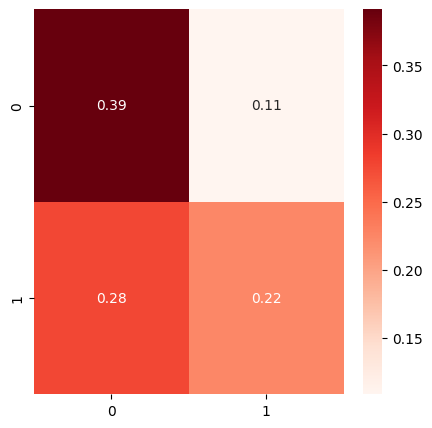

In [47]:
report(y_test, xgb_rfc_best.predict(x_test_selected))

## Бустинги

### Catboost

In [48]:
model = CatBoostClassifier(random_seed=42)

In [49]:
model.fit(
    x_train_selected,
    y_train,
    eval_set=(x_test_selected, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.037982
0:	learn: 0.6815837	test: 0.6911203	best: 0.6911203 (0)	total: 1.87ms	remaining: 1.87s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6773841535
bestIteration = 12

Shrink model to first 13 iterations.


In [50]:
f1_score(y_test, model.predict(x_test_selected))

0.44785276073619634

In [51]:
model.get_feature_importance(catboost.Pool(x_train_selected))

array([36.01458755, 23.90703278,  1.57918619,  8.17654993,  1.65405465,
        5.95472811, 12.44360644, 10.27025435])

In [52]:
def param_search_cb(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_strength": trial.suggest_float("random_strength", 0.5, 2.)
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [53]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(param_search_cb, n_trials=30)

[I 2024-11-24 12:25:09,592] A new study created in memory with name: no-name-3486ba23-9928-40af-ae94-9993a95d74f5
[I 2024-11-24 12:25:13,770] Trial 0 finished with value: 0.48538011695906436 and parameters: {'learning_rate': 0.0051974899176191955, 'depth': 10, 'subsample': 0.5698914751194417, 'colsample_bylevel': 0.44454702661782153, 'min_data_in_leaf': 15, 'random_strength': 1.3548151916462021}. Best is trial 0 with value: 0.48538011695906436.
[I 2024-11-24 12:25:14,736] Trial 1 finished with value: 0.4927536231884059 and parameters: {'learning_rate': 0.044885772627322164, 'depth': 5, 'subsample': 0.05850734128183552, 'colsample_bylevel': 0.8187875526605688, 'min_data_in_leaf': 27, 'random_strength': 1.4798439223533804}. Best is trial 1 with value: 0.4927536231884059.
[I 2024-11-24 12:25:15,543] Trial 2 finished with value: 0.5 and parameters: {'learning_rate': 0.03639210896695526, 'depth': 7, 'subsample': 0.9728439322192236, 'colsample_bylevel': 0.15835948150164944, 'min_data_in_leaf

In [54]:
print('Best hyperparameters:', study_cb.best_params)
print('Best f1 score:', study_cb.best_value)

Best hyperparameters: {'learning_rate': 0.03836876808436583, 'depth': 10, 'subsample': 0.2797724932451232, 'colsample_bylevel': 0.6503712896649088, 'min_data_in_leaf': 80, 'random_strength': 1.4252265174987804}
Best f1 score: 0.5373961218836565


In [55]:
cb_best = CatBoostClassifier(learning_rate=study_cb.best_params['learning_rate'],
                             depth=study_cb.best_params['depth'],
                             random_seed=42,
                             subsample=study_cb.best_params['subsample'],
                             colsample_bylevel=study_cb.best_params['colsample_bylevel'],
                             min_data_in_leaf =study_cb.best_params['min_data_in_leaf'],
                             random_strength=study_cb.best_params['random_strength'])
cb_best.fit(x_train_selected, y_train)

0:	learn: 0.6787577	total: 5.85ms	remaining: 5.84s
1:	learn: 0.6666318	total: 11.4ms	remaining: 5.71s
2:	learn: 0.6519546	total: 16.7ms	remaining: 5.55s
3:	learn: 0.6387681	total: 21.5ms	remaining: 5.36s
4:	learn: 0.6278681	total: 27.3ms	remaining: 5.44s
5:	learn: 0.6182721	total: 32.4ms	remaining: 5.37s
6:	learn: 0.6081286	total: 37.6ms	remaining: 5.33s
7:	learn: 0.5999526	total: 43ms	remaining: 5.33s
8:	learn: 0.5906328	total: 47.1ms	remaining: 5.18s
9:	learn: 0.5820012	total: 53.4ms	remaining: 5.29s
10:	learn: 0.5742005	total: 59.8ms	remaining: 5.38s
11:	learn: 0.5660346	total: 64.4ms	remaining: 5.3s
12:	learn: 0.5580523	total: 69.6ms	remaining: 5.29s
13:	learn: 0.5518275	total: 75.5ms	remaining: 5.32s
14:	learn: 0.5430850	total: 81.5ms	remaining: 5.35s
15:	learn: 0.5373862	total: 86.3ms	remaining: 5.31s
16:	learn: 0.5311890	total: 91.8ms	remaining: 5.31s
17:	learn: 0.5263682	total: 96.4ms	remaining: 5.26s
18:	learn: 0.5209773	total: 101ms	remaining: 5.21s
19:	learn: 0.5155846	total

In [56]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(cb_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

0:	learn: 0.6780289	total: 5.4ms	remaining: 5.39s
1:	learn: 0.6637316	total: 10.8ms	remaining: 5.4s
2:	learn: 0.6470670	total: 15.5ms	remaining: 5.17s
3:	learn: 0.6328315	total: 19.9ms	remaining: 4.95s
4:	learn: 0.6218494	total: 25ms	remaining: 4.97s
5:	learn: 0.6103810	total: 30.4ms	remaining: 5.04s
6:	learn: 0.5995572	total: 36.1ms	remaining: 5.11s
7:	learn: 0.5908112	total: 41.7ms	remaining: 5.17s
8:	learn: 0.5793332	total: 46.1ms	remaining: 5.07s
9:	learn: 0.5684886	total: 52.3ms	remaining: 5.18s
10:	learn: 0.5607631	total: 58.5ms	remaining: 5.26s
11:	learn: 0.5544255	total: 62.9ms	remaining: 5.18s
12:	learn: 0.5457035	total: 68.1ms	remaining: 5.17s
13:	learn: 0.5364524	total: 73.9ms	remaining: 5.2s
14:	learn: 0.5295835	total: 79.4ms	remaining: 5.22s
15:	learn: 0.5215967	total: 84.9ms	remaining: 5.22s
16:	learn: 0.5147563	total: 90.2ms	remaining: 5.21s
17:	learn: 0.5089559	total: 94.7ms	remaining: 5.17s
18:	learn: 0.5036805	total: 99.5ms	remaining: 5.14s
19:	learn: 0.4995028	total:

{'fit_time': array([5.4485383 , 5.69686055, 5.53623962, 5.29283381, 5.27248597]),
 'score_time': array([0.00908208, 0.00992179, 0.01013517, 0.0096972 , 0.00970626]),
 'test_accuracy': array([0.74100719, 0.7146283 , 0.78365385, 0.72115385, 0.73317308]),
 'test_precision_macro': array([0.71321321, 0.67048433, 0.76067983, 0.67810598, 0.6933908 ]),
 'test_recall_macro': array([0.65606029, 0.64976711, 0.72439699, 0.64734414, 0.67740873]),
 'test_f1_macro': array([0.66659757, 0.65612418, 0.73648649, 0.65514679, 0.68335951]),
 'test_roc_auc': array([0.75792862, 0.74381149, 0.78981152, 0.75676816, 0.76621853])}

In [57]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
cb_best_cv_metrics = []
for metric in metrics: cb_best_cv_metrics.append(scores[metric])
cb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
cb_best_cv_metrics = np.array(cb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.57      0.77      0.66       216
           1       0.65      0.43      0.51       216

    accuracy                           0.60       432
   macro avg       0.61      0.60      0.59       432
weighted avg       0.61      0.60      0.59       432

F2-score:  0.4572564612326043


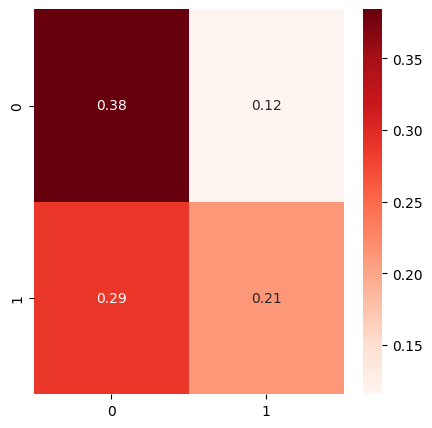

In [58]:
report(y_test, cb_best.predict(x_test_selected))

### XGBoost

In [59]:
model = XGBClassifier()

In [60]:
model.fit(
    x_train_selected,
    y_train,
    )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [61]:
def param_search_xgb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [62]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(param_search_xgb, n_trials=30)

[I 2024-11-24 12:27:02,027] A new study created in memory with name: no-name-09087e9a-bd60-4158-ba8c-9005a7c8c383


[12:27:02] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:02,684] Trial 0 finished with value: 0.5042492917847026 and parameters: {'learning_rate': 0.014747449214589975, 'max_depth': 245, 'n_estimators': 200, 'subsample': 0.6153748186610968, 'colsample_bylevel': 0.7683427720839843, 'gamma': 1.1396625450401199}. Best is trial 0 with value: 0.5042492917847026.


[12:27:02] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:04,627] Trial 1 finished with value: 0.5403899721448469 and parameters: {'learning_rate': 0.07907461143680442, 'max_depth': 197, 'n_estimators': 500, 'subsample': 0.9651899085375638, 'colsample_bylevel': 0.3962715725966711, 'gamma': 1.108011983170064}. Best is trial 1 with value: 0.5403899721448469.


[12:27:04] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:05,761] Trial 2 finished with value: 0.4240506329113924 and parameters: {'learning_rate': 0.001279167704849861, 'max_depth': 404, 'n_estimators': 600, 'subsample': 0.7510075390834163, 'colsample_bylevel': 0.23801515124281758, 'gamma': 1.6682607229691375}. Best is trial 1 with value: 0.5403899721448469.


[12:27:05] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:06,507] Trial 3 finished with value: 0.509915014164306 and parameters: {'learning_rate': 0.036958506544370474, 'max_depth': 330, 'n_estimators': 300, 'subsample': 0.8368220880001752, 'colsample_bylevel': 0.14749969633056897, 'gamma': 1.828451996816194}. Best is trial 1 with value: 0.5403899721448469.


[12:27:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:09,332] Trial 4 finished with value: 0.544943820224719 and parameters: {'learning_rate': 0.0148811857067197, 'max_depth': 135, 'n_estimators': 600, 'subsample': 0.8872001979641521, 'colsample_bylevel': 0.8255525346544118, 'gamma': 2.874389586435973}. Best is trial 4 with value: 0.544943820224719.


[12:27:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:11,484] Trial 5 finished with value: 0.49856733524355307 and parameters: {'learning_rate': 0.0045855441258574655, 'max_depth': 101, 'n_estimators': 700, 'subsample': 0.5521720717957929, 'colsample_bylevel': 0.7223108493524498, 'gamma': 1.4102182356361166}. Best is trial 4 with value: 0.544943820224719.


[12:27:11] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:12,306] Trial 6 finished with value: 0.5028248587570622 and parameters: {'learning_rate': 0.08886994970403989, 'max_depth': 304, 'n_estimators': 300, 'subsample': 0.984758533438705, 'colsample_bylevel': 0.23086048188092867, 'gamma': 0.9863802017202536}. Best is trial 4 with value: 0.544943820224719.


[12:27:12] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:13,017] Trial 7 finished with value: 0.49714285714285716 and parameters: {'learning_rate': 0.011393781504957352, 'max_depth': 438, 'n_estimators': 200, 'subsample': 0.7711537778053531, 'colsample_bylevel': 0.37674496993768325, 'gamma': 2.0916638315689493}. Best is trial 4 with value: 0.544943820224719.


[12:27:13] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:13,261] Trial 8 finished with value: 0.47129909365558914 and parameters: {'learning_rate': 0.027305135827246873, 'max_depth': 345, 'n_estimators': 100, 'subsample': 0.8963197178241772, 'colsample_bylevel': 0.18097126976958505, 'gamma': 2.4005595109509805}. Best is trial 4 with value: 0.544943820224719.


[12:27:13] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:16,841] Trial 9 finished with value: 0.5224719101123595 and parameters: {'learning_rate': 0.003336605426848817, 'max_depth': 464, 'n_estimators': 1000, 'subsample': 0.7172634865627141, 'colsample_bylevel': 0.752809847922985, 'gamma': 0.33978953066401907}. Best is trial 4 with value: 0.544943820224719.


[12:27:16] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:17,949] Trial 10 finished with value: 0.4927536231884059 and parameters: {'learning_rate': 0.0047204717038662174, 'max_depth': 104, 'n_estimators': 900, 'subsample': 0.13955860749676963, 'colsample_bylevel': 0.9803956136891294, 'gamma': 2.781126465534815}. Best is trial 4 with value: 0.544943820224719.


[12:27:17] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:18,703] Trial 11 finished with value: 0.5152354570637119 and parameters: {'learning_rate': 0.0642931474063007, 'max_depth': 196, 'n_estimators': 500, 'subsample': 0.2325723213613653, 'colsample_bylevel': 0.5238161217098513, 'gamma': 0.5606436643968585}. Best is trial 4 with value: 0.544943820224719.


[12:27:18] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:19,730] Trial 12 finished with value: 0.5141242937853108 and parameters: {'learning_rate': 0.027214534690828292, 'max_depth': 186, 'n_estimators': 500, 'subsample': 0.35480538116679616, 'colsample_bylevel': 0.5044815591211138, 'gamma': 0.8279948897881302}. Best is trial 4 with value: 0.544943820224719.


[12:27:19] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:23,811] Trial 13 finished with value: 0.5224719101123595 and parameters: {'learning_rate': 0.05256101906155835, 'max_depth': 170, 'n_estimators': 700, 'subsample': 0.9832977379557013, 'colsample_bylevel': 0.9784542805988536, 'gamma': 2.9805911822847024}. Best is trial 4 with value: 0.544943820224719.


[12:27:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:26,091] Trial 14 finished with value: 0.5274725274725275 and parameters: {'learning_rate': 0.09917412600185908, 'max_depth': 246, 'n_estimators': 800, 'subsample': 0.648008829214862, 'colsample_bylevel': 0.39703901953947107, 'gamma': 2.4318988244157533}. Best is trial 4 with value: 0.544943820224719.


[12:27:26] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:27,080] Trial 15 finished with value: 0.5242165242165242 and parameters: {'learning_rate': 0.017466533478538614, 'max_depth': 156, 'n_estimators': 400, 'subsample': 0.4295886538380257, 'colsample_bylevel': 0.6372619546411915, 'gamma': 0.1394440087967117}. Best is trial 4 with value: 0.544943820224719.


[12:27:27] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:29,759] Trial 16 finished with value: 0.5183098591549297 and parameters: {'learning_rate': 0.007447168523126014, 'max_depth': 242, 'n_estimators': 600, 'subsample': 0.8741642394080112, 'colsample_bylevel': 0.8607120325126185, 'gamma': 1.4067868639662646}. Best is trial 4 with value: 0.544943820224719.


[12:27:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:31,157] Trial 17 finished with value: 0.48967551622418876 and parameters: {'learning_rate': 0.0017023637161278926, 'max_depth': 133, 'n_estimators': 400, 'subsample': 0.9888428597001827, 'colsample_bylevel': 0.3696684969079145, 'gamma': 2.0080128910340616}. Best is trial 4 with value: 0.544943820224719.


[12:27:31] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:32,718] Trial 18 finished with value: 0.4914285714285713 and parameters: {'learning_rate': 0.042892876355419204, 'max_depth': 217, 'n_estimators': 700, 'subsample': 0.4533248513825141, 'colsample_bylevel': 0.6129608390616397, 'gamma': 0.6988996237288433}. Best is trial 4 with value: 0.544943820224719.


[12:27:32] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:34,711] Trial 19 finished with value: 0.523943661971831 and parameters: {'learning_rate': 0.021834151094717286, 'max_depth': 286, 'n_estimators': 800, 'subsample': 0.8331443151820822, 'colsample_bylevel': 0.051980706255771725, 'gamma': 1.112191166219548}. Best is trial 4 with value: 0.544943820224719.


[12:27:34] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:35,982] Trial 20 finished with value: 0.4971098265895953 and parameters: {'learning_rate': 0.008045364066032004, 'max_depth': 143, 'n_estimators': 400, 'subsample': 0.6592977222764025, 'colsample_bylevel': 0.43566614487276273, 'gamma': 2.4622474795459537}. Best is trial 4 with value: 0.544943820224719.


[12:27:36] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:38,879] Trial 21 finished with value: 0.546448087431694 and parameters: {'learning_rate': 0.0954822469705541, 'max_depth': 255, 'n_estimators': 800, 'subsample': 0.9044889600131726, 'colsample_bylevel': 0.30798291415360796, 'gamma': 2.456581391047084}. Best is trial 21 with value: 0.546448087431694.


[12:27:38] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:42,517] Trial 22 finished with value: 0.538888888888889 and parameters: {'learning_rate': 0.06401370168476518, 'max_depth': 281, 'n_estimators': 800, 'subsample': 0.9032666465502713, 'colsample_bylevel': 0.6085388017234856, 'gamma': 2.633576012539605}. Best is trial 21 with value: 0.546448087431694.


[12:27:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:45,832] Trial 23 finished with value: 0.5251396648044693 and parameters: {'learning_rate': 0.09838438448833292, 'max_depth': 207, 'n_estimators': 1000, 'subsample': 0.7953534548241225, 'colsample_bylevel': 0.30696681074260124, 'gamma': 2.9910173944371827}. Best is trial 21 with value: 0.546448087431694.


[12:27:45] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:48,206] Trial 24 finished with value: 0.5280898876404494 and parameters: {'learning_rate': 0.03430524373654345, 'max_depth': 227, 'n_estimators': 600, 'subsample': 0.9379976187150307, 'colsample_bylevel': 0.30195255788948044, 'gamma': 2.1948994768353374}. Best is trial 21 with value: 0.546448087431694.


[12:27:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:51,147] Trial 25 finished with value: 0.5257142857142858 and parameters: {'learning_rate': 0.0588766151003837, 'max_depth': 371, 'n_estimators': 900, 'subsample': 0.7069290299663358, 'colsample_bylevel': 0.4694585267821334, 'gamma': 2.7150113502635196}. Best is trial 21 with value: 0.546448087431694.


[12:27:51] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:53,255] Trial 26 finished with value: 0.5292479108635098 and parameters: {'learning_rate': 0.002497772829728191, 'max_depth': 265, 'n_estimators': 500, 'subsample': 0.9124103897716636, 'colsample_bylevel': 0.8592109522238092, 'gamma': 1.7732739975375522}. Best is trial 21 with value: 0.546448087431694.


[12:27:53] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:55,780] Trial 27 finished with value: 0.5086705202312138 and parameters: {'learning_rate': 0.012767512695274248, 'max_depth': 131, 'n_estimators': 700, 'subsample': 0.8299987864019547, 'colsample_bylevel': 0.31190723652731955, 'gamma': 2.784564586072267}. Best is trial 21 with value: 0.546448087431694.


[12:27:55] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:27:59,456] Trial 28 finished with value: 0.540983606557377 and parameters: {'learning_rate': 0.07446322074706857, 'max_depth': 188, 'n_estimators': 900, 'subsample': 0.9346098947889678, 'colsample_bylevel': 0.5961766341211256, 'gamma': 1.4176683197386564}. Best is trial 21 with value: 0.546448087431694.


[12:27:59] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:02,142] Trial 29 finished with value: 0.526610644257703 and parameters: {'learning_rate': 0.018789861863370817, 'max_depth': 168, 'n_estimators': 900, 'subsample': 0.5721576354416994, 'colsample_bylevel': 0.8088398513483632, 'gamma': 1.4922559262602115}. Best is trial 21 with value: 0.546448087431694.


In [63]:
print('Best hyperparameters:', study_xgb.best_params)
print('Best f1 score:', study_xgb.best_value)

Best hyperparameters: {'learning_rate': 0.0954822469705541, 'max_depth': 255, 'n_estimators': 800, 'subsample': 0.9044889600131726, 'colsample_bylevel': 0.30798291415360796, 'gamma': 2.456581391047084}
Best f1 score: 0.546448087431694


In [64]:
xgb_best = XGBClassifier(learning_rate=study_xgb.best_params['learning_rate'],
                         max_depth=study_xgb.best_params['max_depth'],
                         n_estimators = study_xgb.best_params['n_estimators'],
                         random_seed=42,
                         subsample=study_xgb.best_params['subsample'],
                         colsample_bylevel= study_xgb.best_params['colsample_bylevel'],
                         gamma=study_xgb.best_params['gamma'])
xgb_best.fit(x_train_selected, y_train)

[12:28:02] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.30798291415360796, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.456581391047084, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0954822469705541, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=255, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=42, ...)

In [65]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(xgb_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

[12:28:04] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[12:28:07] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[12:28:09] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[12:28:11] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[12:28:13] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



{'fit_time': array([2.20994711, 2.11464095, 2.24020147, 2.2560029 , 2.28670526]),
 'score_time': array([0.01244259, 0.01163101, 0.01304984, 0.01272464, 0.01148677]),
 'test_accuracy': array([0.71942446, 0.6882494 , 0.76923077, 0.72355769, 0.73557692]),
 'test_precision_macro': array([0.68066578, 0.63553358, 0.74549979, 0.68243425, 0.69676073]),
 'test_recall_macro': array([0.62866339, 0.61691438, 0.70025043, 0.64335047, 0.67149071]),
 'test_f1_macro': array([0.63560113, 0.62160766, 0.71310345, 0.65165471, 0.67950693]),
 'test_roc_auc': array([0.75075884, 0.70551601, 0.8006722 , 0.75270858, 0.77254514])}

In [66]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_best_cv_metrics = []
for metric in metrics: xgb_best_cv_metrics.append(scores[metric])
xgb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_best_cv_metrics = np.array(xgb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.59      0.77      0.67       216
           1       0.67      0.46      0.55       216

    accuracy                           0.62       432
   macro avg       0.63      0.62      0.61       432
weighted avg       0.63      0.62      0.61       432

F2-score:  0.4930966469428008


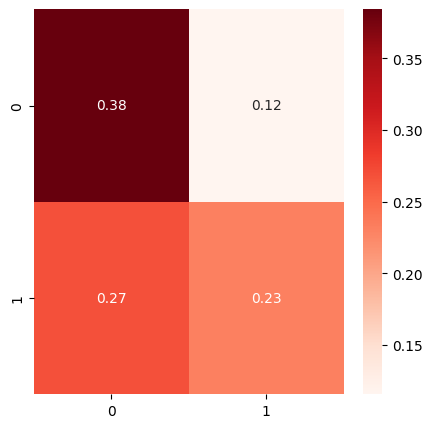

In [67]:
report(y_test, xgb_best.predict(x_test_selected))

### LightGBM

In [68]:
model = LGBMClassifier()

In [69]:
model.fit(
    x_train_selected,
    y_train,
    )

LGBMClassifier()

In [70]:
def param_search_lgbm(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [71]:
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(param_search_lgbm, n_trials=30)

[I 2024-11-24 12:28:16,579] A new study created in memory with name: no-name-4d7e89ee-faa1-4155-967f-af1ef9e1b6e8


[12:28:16] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:17,227] Trial 0 finished with value: 0.4809384164222874 and parameters: {'learning_rate': 0.001248514293310259, 'max_depth': 213, 'n_estimators': 200, 'subsample': 0.7741965664912984, 'colsample_bylevel': 0.3827683895327205, 'gamma': 1.5533002822148947}. Best is trial 0 with value: 0.4809384164222874.


[12:28:17] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:17,438] Trial 1 finished with value: 0.49132947976878616 and parameters: {'learning_rate': 0.03823821001714985, 'max_depth': 247, 'n_estimators': 100, 'subsample': 0.6150084068627972, 'colsample_bylevel': 0.23463681329853892, 'gamma': 2.4150045355535386}. Best is trial 1 with value: 0.49132947976878616.


[12:28:17] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:18,348] Trial 2 finished with value: 0.5071225071225072 and parameters: {'learning_rate': 0.012772732005307047, 'max_depth': 223, 'n_estimators': 500, 'subsample': 0.26287278604943526, 'colsample_bylevel': 0.752798922303125, 'gamma': 1.0756738569702604}. Best is trial 2 with value: 0.5071225071225072.


[12:28:18] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:20,593] Trial 3 finished with value: 0.5439560439560439 and parameters: {'learning_rate': 0.018194372540074583, 'max_depth': 226, 'n_estimators': 500, 'subsample': 0.8670748233867164, 'colsample_bylevel': 0.757770726439604, 'gamma': 1.4484977012767324}. Best is trial 3 with value: 0.5439560439560439.


[12:28:20] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:21,040] Trial 4 finished with value: 0.4957746478873239 and parameters: {'learning_rate': 0.04090624055971662, 'max_depth': 420, 'n_estimators': 500, 'subsample': 0.09017574855663377, 'colsample_bylevel': 0.801693357968534, 'gamma': 0.3501028358449122}. Best is trial 3 with value: 0.5439560439560439.


[12:28:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:22,902] Trial 5 finished with value: 0.5112359550561798 and parameters: {'learning_rate': 0.07027043515046387, 'max_depth': 207, 'n_estimators': 800, 'subsample': 0.9535247539401214, 'colsample_bylevel': 0.17476992194944518, 'gamma': 1.2996004883129884}. Best is trial 3 with value: 0.5439560439560439.


[12:28:22] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:24,099] Trial 6 finished with value: 0.47023809523809523 and parameters: {'learning_rate': 0.006731536105461863, 'max_depth': 498, 'n_estimators': 600, 'subsample': 0.6395835197474721, 'colsample_bylevel': 0.0779047233891245, 'gamma': 1.5488868601218617}. Best is trial 3 with value: 0.5439560439560439.


[12:28:24] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:24,415] Trial 7 finished with value: 0.4809384164222874 and parameters: {'learning_rate': 0.002610761731886034, 'max_depth': 247, 'n_estimators': 100, 'subsample': 0.7642225360566309, 'colsample_bylevel': 0.47126224450238063, 'gamma': 0.2302834014718764}. Best is trial 3 with value: 0.5439560439560439.


[12:28:24] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:25,773] Trial 8 finished with value: 0.49856733524355307 and parameters: {'learning_rate': 0.029547317525268523, 'max_depth': 283, 'n_estimators': 500, 'subsample': 0.9244915327605794, 'colsample_bylevel': 0.1941533853103306, 'gamma': 2.478005949436931}. Best is trial 3 with value: 0.5439560439560439.


[12:28:25] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:26,335] Trial 9 finished with value: 0.48680351906158364 and parameters: {'learning_rate': 0.010112062092133504, 'max_depth': 429, 'n_estimators': 300, 'subsample': 0.3454285371322502, 'colsample_bylevel': 0.4974572608848956, 'gamma': 1.5404590829075486}. Best is trial 3 with value: 0.5439560439560439.


[12:28:26] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:29,074] Trial 10 finished with value: 0.5057471264367817 and parameters: {'learning_rate': 0.004523161579137693, 'max_depth': 107, 'n_estimators': 1000, 'subsample': 0.47063482353346103, 'colsample_bylevel': 0.9181369137732496, 'gamma': 2.9958337444342513}. Best is trial 3 with value: 0.5439560439560439.


[12:28:29] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:32,330] Trial 11 finished with value: 0.5424657534246575 and parameters: {'learning_rate': 0.08521859944239174, 'max_depth': 129, 'n_estimators': 800, 'subsample': 0.9639519434703787, 'colsample_bylevel': 0.6674225293159037, 'gamma': 0.9870263348288928}. Best is trial 3 with value: 0.5439560439560439.


[12:28:32] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:35,674] Trial 12 finished with value: 0.5295774647887324 and parameters: {'learning_rate': 0.09694198808555315, 'max_depth': 101, 'n_estimators': 800, 'subsample': 0.9982812435003076, 'colsample_bylevel': 0.6680940443912461, 'gamma': 0.832400735088169}. Best is trial 3 with value: 0.5439560439560439.


[12:28:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:38,290] Trial 13 finished with value: 0.5280898876404494 and parameters: {'learning_rate': 0.01863414557527855, 'max_depth': 156, 'n_estimators': 700, 'subsample': 0.8053681881736003, 'colsample_bylevel': 0.640700930782299, 'gamma': 0.7443489734553637}. Best is trial 3 with value: 0.5439560439560439.


[12:28:38] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:42,603] Trial 14 finished with value: 0.5546218487394958 and parameters: {'learning_rate': 0.022227348872862502, 'max_depth': 335, 'n_estimators': 1000, 'subsample': 0.8547022544787345, 'colsample_bylevel': 0.9490159297169873, 'gamma': 1.8417661739060596}. Best is trial 14 with value: 0.5546218487394958.


[12:28:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:46,057] Trial 15 finished with value: 0.5254237288135593 and parameters: {'learning_rate': 0.018913302132935877, 'max_depth': 348, 'n_estimators': 1000, 'subsample': 0.6632305982686018, 'colsample_bylevel': 0.9922945209240446, 'gamma': 2.045362003153783}. Best is trial 14 with value: 0.5546218487394958.


[12:28:46] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:47,319] Trial 16 finished with value: 0.5287356321839082 and parameters: {'learning_rate': 0.021323938993979115, 'max_depth': 372, 'n_estimators': 300, 'subsample': 0.8540058299287732, 'colsample_bylevel': 0.8655616543868274, 'gamma': 1.9718803673842706}. Best is trial 14 with value: 0.5546218487394958.


[12:28:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:48,444] Trial 17 finished with value: 0.5056818181818182 and parameters: {'learning_rate': 0.0058838761599455764, 'max_depth': 322, 'n_estimators': 400, 'subsample': 0.5014053959656246, 'colsample_bylevel': 0.9359548610444136, 'gamma': 1.942266321352806}. Best is trial 14 with value: 0.5546218487394958.


[12:28:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:51,626] Trial 18 finished with value: 0.5183098591549297 and parameters: {'learning_rate': 0.051719051148498514, 'max_depth': 304, 'n_estimators': 900, 'subsample': 0.7092991371778797, 'colsample_bylevel': 0.812972287893948, 'gamma': 2.388740962825623}. Best is trial 14 with value: 0.5546218487394958.


[12:28:51] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:53,902] Trial 19 finished with value: 0.5183098591549297 and parameters: {'learning_rate': 0.014238512460104923, 'max_depth': 173, 'n_estimators': 600, 'subsample': 0.8498224085532421, 'colsample_bylevel': 0.5883431581361596, 'gamma': 0.5095636781578856}. Best is trial 14 with value: 0.5546218487394958.


[12:28:53] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:55,430] Trial 20 finished with value: 0.5155807365439093 and parameters: {'learning_rate': 0.025667088922646138, 'max_depth': 391, 'n_estimators': 700, 'subsample': 0.3666844013390555, 'colsample_bylevel': 0.745430802337898, 'gamma': 1.735532029884362}. Best is trial 14 with value: 0.5546218487394958.


[12:28:55] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:28:58,899] Trial 21 finished with value: 0.5386666666666667 and parameters: {'learning_rate': 0.098142618778835, 'max_depth': 157, 'n_estimators': 900, 'subsample': 0.9012027036095448, 'colsample_bylevel': 0.6899308909131872, 'gamma': 1.1405185905744535}. Best is trial 14 with value: 0.5546218487394958.


[12:28:58] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:29:02,810] Trial 22 finished with value: 0.554945054945055 and parameters: {'learning_rate': 0.05467706965587266, 'max_depth': 273, 'n_estimators': 900, 'subsample': 0.9977917044322993, 'colsample_bylevel': 0.594879364600907, 'gamma': 1.273692693815024}. Best is trial 22 with value: 0.554945054945055.


[12:29:02] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:29:06,286] Trial 23 finished with value: 0.5168539325842697 and parameters: {'learning_rate': 0.044323250314114514, 'max_depth': 260, 'n_estimators': 1000, 'subsample': 0.8729287853551663, 'colsample_bylevel': 0.37815545518180094, 'gamma': 1.3202452645831293}. Best is trial 22 with value: 0.554945054945055.


[12:29:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:29:08,711] Trial 24 finished with value: 0.5284090909090909 and parameters: {'learning_rate': 0.055222996817202344, 'max_depth': 325, 'n_estimators': 900, 'subsample': 0.565347728500847, 'colsample_bylevel': 0.8843038937676349, 'gamma': 1.7689125291295955}. Best is trial 22 with value: 0.554945054945055.


[12:29:08] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:29:10,976] Trial 25 finished with value: 0.5236768802228412 and parameters: {'learning_rate': 0.030282734274362767, 'max_depth': 279, 'n_estimators': 700, 'subsample': 0.719597661216699, 'colsample_bylevel': 0.5729815280391678, 'gamma': 1.3325246432204647}. Best is trial 22 with value: 0.554945054945055.


[12:29:11] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:29:12,791] Trial 26 finished with value: 0.5242165242165242 and parameters: {'learning_rate': 0.013368528139896408, 'max_depth': 191, 'n_estimators': 400, 'subsample': 0.8192482209677919, 'colsample_bylevel': 0.9796945001316797, 'gamma': 2.2074032358876488}. Best is trial 22 with value: 0.554945054945055.


[12:29:12] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:29:17,434] Trial 27 finished with value: 0.5295774647887324 and parameters: {'learning_rate': 0.007711287386929529, 'max_depth': 344, 'n_estimators': 900, 'subsample': 0.9934611954717905, 'colsample_bylevel': 0.8140520163073431, 'gamma': 1.7799028919291575}. Best is trial 22 with value: 0.554945054945055.


[12:29:17] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:29:20,575] Trial 28 finished with value: 0.5251396648044693 and parameters: {'learning_rate': 0.06246587680044604, 'max_depth': 290, 'n_estimators': 1000, 'subsample': 0.9109008608204809, 'colsample_bylevel': 0.3827645900788967, 'gamma': 0.7008825965380575}. Best is trial 22 with value: 0.554945054945055.


[12:29:20] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-24 12:29:21,858] Trial 29 finished with value: 0.49283667621776495 and parameters: {'learning_rate': 0.001422480469206175, 'max_depth': 218, 'n_estimators': 400, 'subsample': 0.7516999060801867, 'colsample_bylevel': 0.7259529821884567, 'gamma': 1.4907109308798012}. Best is trial 22 with value: 0.554945054945055.


In [72]:
print('Best hyperparameters:', study_lgbm.best_params)
print('Best f1 score:', study_lgbm.best_value)

Best hyperparameters: {'learning_rate': 0.05467706965587266, 'max_depth': 273, 'n_estimators': 900, 'subsample': 0.9977917044322993, 'colsample_bylevel': 0.594879364600907, 'gamma': 1.273692693815024}
Best f1 score: 0.554945054945055


In [73]:
lgbm_best = LGBMClassifier(learning_rate=study_lgbm.best_params['learning_rate'],
                             max_depth=study_lgbm.best_params['max_depth'],
                             n_estimators = study_lgbm.best_params['n_estimators'],
                             random_seed=42,
                             subsample=study_lgbm.best_params['subsample'])
lgbm_best.fit(x_train_selected, y_train)

LGBMClassifier(learning_rate=0.05467706965587266, max_depth=273,
               n_estimators=900, random_seed=42, subsample=0.9977917044322993)

In [74]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(lgbm_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([0.5312295 , 0.5437057 , 0.55466318, 0.55792809, 0.5311985 ]),
 'score_time': array([0.02202606, 0.02342153, 0.02328134, 0.02178955, 0.02250814]),
 'test_accuracy': array([0.69784173, 0.6498801 , 0.75480769, 0.71394231, 0.70673077]),
 'test_precision_macro': array([0.64619025, 0.59391498, 0.72450053, 0.66948276, 0.66160527]),
 'test_recall_macro': array([0.61075204, 0.58844463, 0.68572558, 0.65547647, 0.65206274]),
 'test_f1_macro': array([0.61547131, 0.59031815, 0.696767  , 0.66053857, 0.65581597]),
 'test_roc_auc': array([0.73343626, 0.6874215 , 0.76505865, 0.7426519 , 0.75206274])}

In [75]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
lgbm_best_cv_metrics = []
for metric in metrics: lgbm_best_cv_metrics.append(scores[metric])
lgbm_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
lgbm_best_cv_metrics = np.array(lgbm_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.58      0.77      0.66       216
           1       0.66      0.44      0.53       216

    accuracy                           0.61       432
   macro avg       0.62      0.61      0.60       432
weighted avg       0.62      0.61      0.60       432

F2-score:  0.4712301587301587


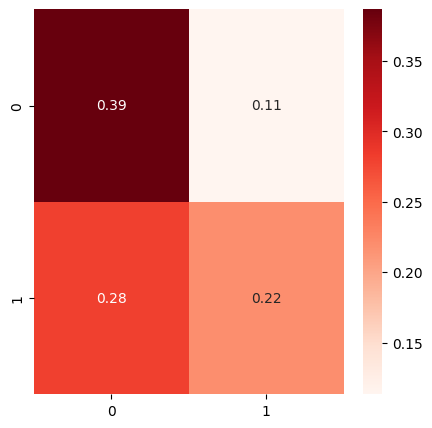

In [76]:
report(y_test, lgbm_best.predict(x_test_selected))

# Результаты

In [77]:
best_models = [rfc_best, xgb_rfc_best, xgb_best, lgbm_best, cb_best]

In [78]:
best_models_cv_metrics = [rfc_best_cv_metrics, xgb_rfc_best_cv_metrics, xgb_best_cv_metrics, lgbm_best_cv_metrics, cb_best_cv_metrics]

In [79]:
def test_results(model, x_test, y_true):
  y_pred = model.predict(x_test)
  round_num = 2
  result_dict = {
      "Accuracy": round(accuracy_score(y_true, y_pred), round_num),
      "AUC": round(roc_auc_score(y_true, y_pred), round_num),
      "Precision": round(precision_score(y_true, y_pred), round_num),
      "Recall": round(recall_score(y_true, y_pred), round_num),
      "F1-score": round(f1_score(y_true, y_pred), round_num),
      "F2-score": round(f2_score(y_true, y_pred), round_num)
  }
  return result_dict

In [80]:
round_num = 2
for metrics in best_models_cv_metrics:
  print("'Accuracy':", round(np.mean(metrics[0]), round_num),"+-",round(np.std(metrics[0]), round_num),",",
        "'AUC':", round(np.mean(metrics[1]), round_num),"+-",round(np.std(metrics[1]), round_num),","
        "'Precision':", round(np.mean(metrics[2]), round_num),"+-",round(np.std(metrics[2]), round_num),","
        "'Recall':", round(np.mean(metrics[3]), round_num),"+-",round(np.std(metrics[3]), round_num),","
        "'F1-score':", round(np.mean(metrics[4]), round_num),"+-",round(np.std(metrics[4]), round_num),","
        "'F2-score':", round(np.mean(metrics[5]), round_num),"+-",round(np.std(metrics[5]), round_num),)

'Accuracy': 0.81 +- 0.01 , 'AUC': 0.87 +- 0.01 ,'Precision': 0.79 +- 0.01 ,'Recall': 0.76 +- 0.01 ,'F1-score': 0.77 +- 0.01 ,'F2-score': 0.76 +- 0.01
'Accuracy': 0.74 +- 0.03 , 'AUC': 0.77 +- 0.03 ,'Precision': 0.7 +- 0.04 ,'Recall': 0.66 +- 0.04 ,'F1-score': 0.67 +- 0.04 ,'F2-score': 0.67 +- 0.04
'Accuracy': 0.73 +- 0.03 , 'AUC': 0.76 +- 0.03 ,'Precision': 0.69 +- 0.04 ,'Recall': 0.65 +- 0.03 ,'F1-score': 0.66 +- 0.03 ,'F2-score': 0.66 +- 0.03
'Accuracy': 0.7 +- 0.03 , 'AUC': 0.74 +- 0.03 ,'Precision': 0.66 +- 0.04 ,'Recall': 0.64 +- 0.03 ,'F1-score': 0.64 +- 0.04 ,'F2-score': 0.64 +- 0.04
'Accuracy': 0.74 +- 0.02 , 'AUC': 0.76 +- 0.02 ,'Precision': 0.7 +- 0.03 ,'Recall': 0.67 +- 0.03 ,'F1-score': 0.68 +- 0.03 ,'F2-score': 0.68 +- 0.03


In [81]:
for model in best_models:
  if model == rfc_best: print(test_results(model, x_val_imp, y_val))
  else: print(test_results(model, x_val_selected, y_val))

{'Accuracy': 0.78, 'AUC': 0.72, 'Precision': 0.7, 'Recall': 0.55, 'F1-score': 0.62, 'F2-score': 0.58}
{'Accuracy': 0.75, 'AUC': 0.68, 'Precision': 0.65, 'Recall': 0.47, 'F1-score': 0.54, 'F2-score': 0.49}
{'Accuracy': 0.74, 'AUC': 0.66, 'Precision': 0.63, 'Recall': 0.43, 'F1-score': 0.51, 'F2-score': 0.46}
{'Accuracy': 0.71, 'AUC': 0.64, 'Precision': 0.57, 'Recall': 0.43, 'F1-score': 0.49, 'F2-score': 0.45}
{'Accuracy': 0.73, 'AUC': 0.65, 'Precision': 0.61, 'Recall': 0.44, 'F1-score': 0.51, 'F2-score': 0.47}


In [82]:
for model in best_models:
  if model == rfc_best: print(test_results(model, x_test_imp, y_test))
  else: print(test_results(model, x_test_selected, y_test))

{'Accuracy': 0.59, 'AUC': 0.59, 'Precision': 0.68, 'Recall': 0.33, 'F1-score': 0.44, 'F2-score': 0.37}
{'Accuracy': 0.62, 'AUC': 0.62, 'Precision': 0.67, 'Recall': 0.45, 'F1-score': 0.54, 'F2-score': 0.48}
{'Accuracy': 0.62, 'AUC': 0.62, 'Precision': 0.67, 'Recall': 0.46, 'F1-score': 0.55, 'F2-score': 0.49}
{'Accuracy': 0.61, 'AUC': 0.61, 'Precision': 0.66, 'Recall': 0.44, 'F1-score': 0.53, 'F2-score': 0.47}
{'Accuracy': 0.6, 'AUC': 0.6, 'Precision': 0.65, 'Recall': 0.43, 'F1-score': 0.51, 'F2-score': 0.46}


In [83]:
import shap
shap.initjs()

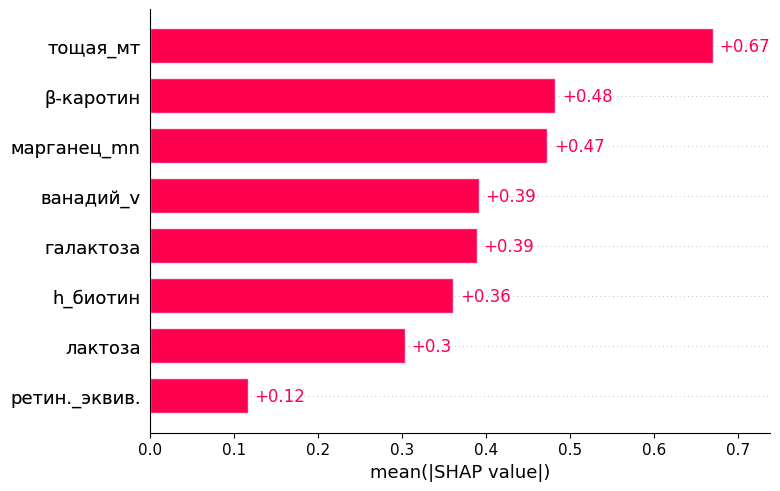

In [84]:
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer(x_train_selected)
shap.plots.bar(shap_values)

In [85]:
file_names = ["RFClassifier.txt","XGBRFClassifier.txt","XGBoostClassifier.txt","LightGBMClassifier.txt","CatBoostClassifier.txt"]
for i in range(len(best_models)):
    file = open(file_names[i], "w")
    file.write(str(best_models[i].feature_importances_))
    file.close()